## README ❗

Set a manual_seed for reproducibility.

References:

- See [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html)





## Environment setup 🏛


In [1]:
! pip install python-dotenv
! pip install monai
! pip install shutil
! pip install mlflow --quiet
! pip install pyngrok --quiet
! pip install torchmetrics
#! pip install dgl
! pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html


import os
import re
import sys
from google.colab import drive

drive.mount('/content/drive/')
sys.path.append('/content/drive/MyDrive/Lorusso/BraTS/')

from src.preprocess import evaluation
from src.preprocess.image_processing import *
from src.preprocess.nifti_io import *
from src.preprocess.graphgen import *
from src.preprocess.graph_io import *

from mlflow.models.signature import infer_signature
import mlflow
import mlflow.pytorch
from pyngrok import ngrok

import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import concurrent.futures
import tarfile
import nibabel as nib
import glob
import random
import shutil
import time
from distutils.dir_util import copy_tree
from collections import Counter
from sklearn.model_selection import train_test_split


import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler
from torchvision import utils

from monai.networks.nets import AutoEncoder
from monai.losses import DiceCELoss, DiceFocalLoss, DiceLoss, FocalLoss

from dgl import from_networkx as to_dgl_graph
from dgl import batch as dgl_batch

#torch.use_deterministic_algorithms(True, warn_only=True)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
Looking in links: https://data.dgl.ai/wheels/cu121/repo.html
Looking in links: https://data.dgl.ai/wheels-test/repo.html
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Using cuda device


In [2]:
%%bash

if [ ! -f '/content/drive/MyDrive/Lorusso/BraTS/.env' ]; then
    echo "Creating .env file..."
    echo "INPUT_DATA_DIR='/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats'" > '/content/drive/MyDrive/Lorusso/BraTS/.env'
    echo "PROCESSED_DATA_DIR='/content/drive/MyDrive/Lorusso/BraTS/data/processed'" >> '/content/drive/MyDrive/Lorusso/BraTS/.env'
    echo "LOG_PATH='/content/drive/MyDrive/Lorusso/BraTS/logs'" >> '/content/drive/MyDrive/Lorusso/BraTS/.env'
fi

In [3]:
%%bash

if [ ! -f '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2021_Training_Data.tar'  ]; then
    echo "Downloading BraTS dataset at /content/drive/MyDrive/Lorusso/BraTS/data/raw ..."
    mkdir /root/.kaggle/
    cp '/content/drive/MyDrive/Lorusso/kaggle.json' /root/.kaggle
    chmod 600 '/root/.kaggle/kaggle.json'
    cd '/content/drive/MyDrive/Lorusso/BraTS/data/raw' && kaggle datasets download -d dschettler8845/brats-2021-task1
    ls '/content/drive/MyDrive/Lorusso/BraTS/data/raw'
    unzip '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats-2021-task1.zip' -d '/content/drive/MyDrive/Lorusso/BraTS/data/raw/'
    rm -r '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats-2021-task1.zip'
fi

In [4]:
%%bash
path='/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats'
dst='/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/'


if [ ! -d '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled' ]; then

    mkdir '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled'

    rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/train
    rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/test
    rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/val

    for el in $(ls $path | head -n 24);
        do
            echo "$path/$el -> $dst"
            cp -R "$path/$el" $dst
        done
fi


## MLFlow server

In [5]:
mlflow.set_tracking_uri('file:///content/drive/MyDrive/Lorusso/BraTS/mlruns')

# Terminate open tunnels if exist
ngrok.kill()
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2Yliuv8VnNyKNcljxgEv6NpZgz8_6ZDBYmEcebUeoX93eGJAE"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --backend-store-uri file:///content/drive/MyDrive/Lorusso/BraTS/mlruns --port 5000 & ")


MLflow Tracking UI: https://69d3-34-82-82-241.ngrok-free.app


## Utils 🛠

In [6]:
class Logger:
    def __init__(self,filename):
        self.filename = filename
        try:  #try to open file in 'r' (read) mode, if file does not exists the statement will throw an IOexception
            log_file = open(self.filename, "r")
            log_file.close()
        except Exception as e: #catch the Exception raised from the block above and create the missing file in the specified path
            log_file = open(self.filename, "w")
            log_file.close()

    def log_msg(self,*args):
        try:
            with open(self.filename, "a+") as log_file:
                for el in args:
                    if(type(el) is list or type(el) is tuple):
                        for subel in el:
                            log_file.write(subel)
                            log_file.write('\n')
                    else:
                        log_file.write(el)
                        log_file.write('\n')
        except Exception as e:
            print('Exception in Logger.log_msg')
            print(e)

    def read_msg(self):
        content = []
        try:
            with open(self.filename) as file:
                for el in file:
                    content.append(el)
        except Exception as e:
            print('Exception in Logger.read_msg')
            print(e)
        finally:
            return content





def untar_brats(tar_path, extract_path):
    tar = tarfile.open(tar_path)
    tar.extractall(extract_path)
    tar.close()


def seg_to_challenge( src = '/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.5_0/BraTS2023-ValidationData',
                     dst =  '/content/drive/MyDrive/Lorusso/BraTS/data/segmentation/BraTS2023-ValidationData/'):
    for mri_id in os.listdir(src):
        for el in os.listdir(os.path.join(src, mri_id)):
            if(not (el.endswith('_input.nii.gz') or el.endswith('.json') or el.endswith('_supervoxels.nii.gz') or el.endswith('.pkl')) ):
                shutil.copy2(os.path.join(src,mri_id,el), dst)
                os.rename(os.path.join(dst,el), f"{dst}{os.sep}{mri_id}.nii.gz")

def rm_run(experiment_name,run_id):
    current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
    experiment_id = current_experiment['experiment_id']
    for el in run_id:
        rm_path = '/content/drive/MyDrive/Lorusso/BraTS/mlruns/'+experiment_id+'/'+el
        shutil.rmtree(rm_path)


def plot_reconstruction(im_orig, im_rec, ax:int = 0, slice_index:int = 100):

    f, ax_array = plt.subplots(1,2, figsize=(10,10))
    ax_array[0].imshow(np.take(im_orig, indices = slice_index, axis = ax), cmap='gray')
    ax_array[1].imshow(np.take( im_rec , indices=slice_index, axis = ax), cmap='gray')

def plot_brain_sections(img,labels, ax = 1,slice_index = 90):

    """
    """
    assert(img.shape[:3] == labels.shape)
    img = img.T
    labels = labels.T
    d1,d2,d3 = np.shape(lab)
    dims = [d1,d2,d3]
    dims.pop(ax)
    color_segmentation = np.zeros((dims[0],dims[1],3))

    gray_segmentation = np.take(img,slice_index,axis = ax)
    color_segmentation[gray_segmentation == 1] = [255,0,0] # Red (necrotic tumor core)
    color_segmentation[gray_segmentation == 2] = [0,255,0] # Green (peritumoral edematous/invaded tissue)
    color_segmentation[gray_segmentation == 3] = [0,0,255] # Blue (enhancing tumor)

    t1 = img[0]
    flair = img[1]
    t2 = img[2]
    t1ce = img[3]

    image = t1+t2+flair+t1ce

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(np.take(image,slice_index,axis = 0),cmap='gray')

    plt.subplot(1,4,2)
    plt.imshow(np.take(image,slice_index,axis = 1),cmap='gray')

    plt.subplot(1,4,3)
    plt.imshow(np.take(image,slice_index,axis = 2),cmap='gray')

    plt.subplot(1,4,4)
    plt.imshow(color_segmentation,cmap='gray')
    plt.xlabel('Segmentation')


def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().permute((1, 2, 0)))


def count_labels(triple_list):
    label_counts = {}
    labels = [triple[3] for triple in triple_list]

    # Concatenate all the arrays into one
    all_labels = np.concatenate(labels)

    # Count the occurrences of each label
    counter = Counter(all_labels)

    # Create a dict with the counts for labels 1 to 4
    counts_dict = {i: counter[i] for i in counter.keys()}
    return counts_dict


def class_weights_tensor(label_weights):
    num_classes = max(label_weights.keys())+1
    weight_tensor = torch.zeros(num_classes, dtype=torch.float32)
    # Sort the dictionary by keys (labels)
    sorted_label_weights = sorted(label_weights.items(), key=lambda x: x[0])
    for label, weight in sorted_label_weights:
        weight_tensor[label] = weight  # Subtract 1 from label if your labels start from 1
    return weight_tensor


def compute_average_weights(graphs):
    label_counts = count_labels(graphs)
    total_count = sum(label_counts.values())
    class_weights = {label: total_count / count for label, count in label_counts.items()}
    weight_tensor = class_weights_tensor(class_weights)
    return weight_tensor



## Dataset class  💾


In [7]:
'''
Preprocessing script to convert from data provided by BraTS to data used by our model. Should be the first thing you run.
Fulfills the following four functions:
1. Normalize and standardize each image of each MRI modality
2. Combine multiple MRI modalitities into one image array
3. Swap labels from BraTS order (0,2,1,4) to more intuitive order (0,1,2,3)
4. Convert image into a graph
    Using Simple Linear Iterative Clustering algorithm
    Parameters passed on command line

If no labels are present (e.g. at test time, in deployment) can also build graph without labels.

Saves the following in the specified output directory for each sample
MRI_ID/
    _input.nii.gz (processed and combined modalities for a sample as nifti file)
    _label.nii.gz
    _nxgraph.json (networkx graph containing both graph topography and features and labels for each node)
    _supervoxels.nii.gz (supervoxel partitioning produced by SLIC)
    _crop.npy (optionally the crop of the processed data relative to the original data) (crops out empty image planes)
'''

LABEL_MAP = {4: 3, 2: 1, 1: 2}


def swap_labels_from_brats(label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 4]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == 4] = LABEL_MAP[4]
    new_label_data[label_data == 2] = LABEL_MAP[2]
    new_label_data[label_data == 1] = LABEL_MAP[1]
    return new_label_data

def swap_labels_to_brats(label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 3]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == LABEL_MAP[4]] = 4
    new_label_data[label_data == LABEL_MAP[2]] = 2
    new_label_data[label_data == LABEL_MAP[1]] = 1
    return new_label_data


def swap_labels_to_brats_2023(label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 3]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == LABEL_MAP[4]] = 3
    new_label_data[label_data == LABEL_MAP[2]] = 2
    new_label_data[label_data == LABEL_MAP[1]] = 1
    return new_label_data

class DataPreprocessor(Dataset):
    def __init__(self, dotenv_path = "/content/drive/MyDrive/Lorusso/BraTS/.env", transform:bool = True, INPUT_PATH = None,
                 num_nodes = 15000, boxiness_coef = 0.5, num_neighbors = 0, **kwargs):

        load_dotenv(dotenv_path)
        # Data mean and variance
        data_stats = ([0.4645, 0.6625, 0.4064, 0.3648],
                      [0.1593, 0.1703, 0.1216, 0.1627])
        self.N_THREADS = 8
        self.num_nodes = num_nodes
        self.boxiness_coef = boxiness_coef
        self.num_neighbors = num_neighbors

        if(INPUT_PATH is not None and os.path.exists(INPUT_PATH)):
            self.data_dir = INPUT_PATH
        else:
            self.data_dir = os.getenv('INPUT_DATA_DIR')

        self.output_dir = os.getenv('PROCESSED_DATA_DIR')
        self.graph_dir = f"{self.output_dir}_{self.num_nodes}_{self.boxiness_coef}_{self.num_neighbors}{os.sep}{os.path.basename(self.data_dir)}"
        self.logger = Logger(filename=os.path.join(os.getenv('LOG_PATH'), os.path.basename(self.data_dir)+'_logs.txt'))

        self.mri_prefix = 'BraTS2021_'
        self.modality_extensions = ["_flair.nii.gz", "_t1.nii.gz", "_t1ce.nii.gz", "_t2.nii.gz"]
        self.label_extension = "_seg.nii.gz"
        self.dataset_mean = np.array(data_stats[0], dtype=np.float32)
        self.dataset_std = np.array(data_stats[1], dtype=np.float32)
        self.transform = transform
        self.force_conversion = False

        # Set or overwrite additional attributes
        for el in kwargs.keys():
            setattr(self,str(el),kwargs[el])

        self.include_labels = self.label_extension is not None
        self.all_ids, self.id_to_fp = self.get_all_mris_in_dataset()

    def __len__(self):
        return len(self.all_ids)


    def __getitem__(self,idx):
        # DO NOT APPLY PADDING!! See this issue:
        # https://github.com/RobertoLorusso/BraTS/issues/10#issue-2065431255
        #imstack, labels = self.padding(imstack, labels)

        imstack = self.read_in_patient_sample(idx)
        if(self.include_labels):
            labels = self.read_in_labels(idx)
        else:
            labels = None
        crop_idxs = None

        if (self.transform):
            imstack,labels,crop_idxs = self.get_standardized_image(imstack, labels)
        return imstack, labels, crop_idxs


    def read_in_patient_sample(self, mri_id):

        scan_dir = self.data_dir + os.sep + mri_id
        modality_exts = self.modality_extensions
        num_modalities=len(modality_exts)
        modality_imgs = []
        for root, _, files in os.walk(scan_dir):
            for ext in modality_exts:
                for filename in files:
                    if filename.endswith(ext):
                        filepath = os.path.join(root, filename)
                        mod_img = nib.load(filepath)
                        #data is actually stored as int16
                        img_data = np.array(mod_img.dataobj,dtype=np.float32)
                        modality_imgs.append(img_data)
        #check that all the modalities were present in the folder
        assert(len(modality_imgs)==num_modalities)

        patient_sample = np.stack(modality_imgs,3) if num_modalities>1 else modality_imgs[0]
        return patient_sample


    def read_in_labels(self,mri_id):
        scan_dir = self.data_dir + os.sep + mri_id
        for filename in os.listdir(scan_dir):
            if filename.endswith(self.label_extension):
                label_nib = nib.load(scan_dir+os.sep+filename)
                #potentially also return affine if they are different between images (which they are not for brats)
                return np.array(label_nib.dataobj,dtype=np.int16)
        raise FileNotFoundError(f"Label image not found in folder: {scan_dir}")


    def get_all_mris_in_dataset(self):
        mri_folders = glob.glob(f"{self.data_dir}**/{self.mri_prefix}*/",
                                recursive=True)
        mri_folders = self.remove_incomplete_mris(mri_folders)
        scan_dic = {os.path.split(fp)[0].split("/")[-1]: fp for fp in mri_folders}
        if(len(mri_folders) == 0):
            print("No MRI found at " + self.data_dir)
        return list(scan_dic.keys()), scan_dic


    def remove_incomplete_mris(self, mri_folders):
        # if there are any you want to ignore just add them to this list
        removed_mris = []
        return [fp for fp in mri_folders if fp.split("/")[-2] not in removed_mris]

    def padding(self,image, labels):
        n_channels = np.shape(image)[0]
        max_val = max(np.shape(image))
        pad_list = np.zeros([n_channels,max_val,max_val,max_val],dtype=np.float32)

        for channel in range(0, n_channels): # pad every channel
            pad_list[channel] = np.pad(image[channel],[(42,43),(0,0),(0,0)],'constant')
        labels = np.pad(labels, [(42,43),(0,0),(0,0)],'constant')

        return pad_list, labels


    def get_standardized_image(self, image_data, label_data):

        #standardized_labels = self.swap_labels_from_brats(label_data)

        crop_idxs = self.determine_brain_crop(image_data)
        cropped_data = image_data[crop_idxs]
        if(self.include_labels):
            cropped_labels = label_data[crop_idxs]
            standardized_labels= swap_labels_from_brats(cropped_labels)
        else:
            standardized_labels = None

        normalized_data = self.normalize_img_quantile(cropped_data)
        standardized_data = self.standardize_img(normalized_data)
        return standardized_data,standardized_labels,crop_idxs


    def determine_brain_crop(self,multi_modal_data):
        if(len(multi_modal_data.shape)==4):
            max_intensity_vals = np.amax(multi_modal_data,axis=3)
        elif(len(multi_modal_data.shape)==3):
            max_intensity_vals = multi_modal_data
        else:
            raise Exception(f"Expected input shape of either nxmxr or nxmxrxC. Instead got {multi_modal_data.shape}")
        mask = max_intensity_vals>0.01
        ix = np.ix_(mask.any(axis=(1,2)),mask.any(axis=(0,2)),mask.any(axis=(0,1)))

        return ix

    def normalize_img(self, img_array):
        new_image = np.zeros(img_array.shape, dtype=np.float32)
        n_channel = img_array.shape[3] # channel-first images

        for channel in range(0, n_channel): # normalize every channel

            maxval, minval= np.max(img_array[channel]), np.min(img_array[channel])
            new_image[channel] = (img_array[channel] - minval)/(maxval-minval)
        return new_image


    def normalize_img_quantile(self, img_array):
        # Exclude the channel axis, for channel-first images is zero
        quantile = np.quantile(img_array, 0.995, axis = (0,1,2) ).astype(np.float32)
        img_array = img_array/quantile
        return img_array



    def standardize_img(self,img_array):
        centered = img_array-self.dataset_mean
        standardized = centered/self.dataset_std
        return standardized


    def get_status_ids(self):

        common_ids = set()
        converting_ids = set()
        finished_ids = set()

        finished = []
        pending = []

        try:
            regex = r'(Converting|Finished) ' + self.mri_prefix + '(\d+)([-_]\d+)?'

            content = self.logger.read_msg()

            # Define the regular expression pattern
            pattern = re.compile(regex)
            # Find all occurrences in the list
            matches = [match.groups() for s in content if (match := pattern.match(s))]

            for action, brats_id, suffix in matches:
                if action == 'Converting':
                    if(suffix is not None):
                        converting_ids.add(self.mri_prefix + brats_id + suffix)
                    else:
                        converting_ids.add(self.mri_prefix + brats_id)
                elif action == 'Finished':
                    if(suffix is not None):
                        finished_ids.add(self.mri_prefix + brats_id + suffix)
                    else:
                        finished_ids.add(self.mri_prefix + brats_id)
            # Find finished and pending conversions
            common_ids = converting_ids.intersection(finished_ids)
            finished = [el for el in common_ids]
            pending = [el for el in converting_ids.difference(common_ids)]

        except Exception as e:
            print('Exception in DataPreprocessor.get_status_ids')
            print(e)

        return {'Finished':finished, 'Pending':pending}




    def remove_pending_graphs(self):

        pending = self.get_status_ids()['Pending']

        for mri_id in pending:
            remove_path = f"{self.graph_dir}{os.sep}{mri_id}"
            try:
                print('Removing pending graph: ' + remove_path)
                shutil.rmtree(remove_path)
            except Exception as e:
                print('Exception in DataPreprocessor.remove_pending_graphs:')
                print(e)



    def split_dataset(self, fixed = (1001, 125, 125),seed = 42):

        random.seed(seed)
        pos = random.sample(range(0,len(self.all_ids)), len(self.all_ids))

        if fixed:
            if(np.sum(fixed) != len(self.all_ids)):
                print("Error: fixed ratio does not sum up to one.\nSwitching to default (1001,125,125))")
                fixed = (1001,125,125)

            train_length = fixed[0]
            val_length = fixed[1]
            test_length = fixed[2]


        split_dict = {
            'train': [self.all_ids[i] for i in pos[:train_length]],
            'val': [self.all_ids[i] for i in pos[train_length :train_length + val_length]],
            'test': [self.all_ids[i] for i in pos[train_length + val_length:]]
        }

        for k in split_dict.keys():
            parent = '/'.join(self.data_dir.split('/')[:-1])
            dst = os.path.join(parent,k)

            try:
              # create train,val,test dirs
              if(not os.path.exists(dst)):
                os.mkdir(dst)

              # copy splitted data inside folders
              for id in split_dict[k]:
                if(not os.path.exists(os.path.join(dst,id))):
                   os.mkdir(os.path.join(dst,id))
                copy_tree(self.id_to_fp[id],os.path.join(dst,id))

            except Exception as e:
              print(f"Exception thrown in class {self.__class__.__name__ }, method split_dataset")
              print(e)




    def image_to_graph(self, mri_id):


        save_path = f"{self.graph_dir}{os.sep}{mri_id}"
        finished = self.get_status_ids()['Finished']

        if(mri_id not in finished):
            self.logger.log_msg('Converting ' + str(mri_id))
        print('Converting ' + str(mri_id))

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        if(not os.path.exists(f"{save_path}{os.sep}{mri_id}_input.nii.gz") or self.force_conversion == True):
            imstack, labels, crop_idxs = self.__getitem__(mri_id)
        else:
            imstack, labels = self.get_image(mri_id)

        # Load supervoxels, if already exist, and save computational time avoiding the runnning of slic
        sv_partitioning = None
        if(os.path.exists(f"{save_path}{os.sep}{mri_id}_supervoxels.nii.gz")):
            sv_partitioning = self.get_supervoxel_partitioning(mri_id)
            print('Loading supervoxels for mri' + str(mri_id))

        nx_graph,node_feats,region_img = img2graph(imstack,labels,sv_partitioning,self.num_nodes,self.boxiness_coef,self.num_neighbors)

        save_networkx_graph(nx_graph, f"{save_path}{os.sep}{mri_id}_nxgraph.json")
        save_as_nifti(imstack,f"{save_path}{os.sep}{mri_id}_input.nii.gz")
        if(self.include_labels):
            save_as_nifti(labels,f"{save_path}{os.sep}{mri_id}_label.nii.gz")
        save_as_nifti(region_img,f"{save_path}{os.sep}{mri_id}_supervoxels.nii.gz")

        with open(f"{save_path}{os.sep}{mri_id}_crop.pkl", "wb") as f:
            pickle.dump(crop_idxs, f)

        return mri_id

    def get_voxel_labels(self,mri_id):
        fp=f"{self.graph_dir}{os.sep}{mri_id}{os.sep}{mri_id}_label.nii.gz"
        return read_nifti(fp,np.int16)

    def get_image(self,mri_id):
        fp = f"{self.graph_dir}{os.sep}{mri_id}{os.sep}{mri_id}_input.nii.gz"
        img = read_nifti(fp,np.float32)
        return img,self.get_voxel_labels(mri_id)


    def get_supervoxel_partitioning(self,mri_id):
        fp=f"{self.graph_dir}{os.sep}{mri_id}{os.sep}{mri_id}_supervoxels.nii.gz"
        return read_nifti(fp,np.int16)

    def run(self):

        self.remove_pending_graphs()

        with concurrent.futures.ThreadPoolExecutor(max_workers=self.N_THREADS) as executor:
            futures = [executor.submit(self.image_to_graph, mri_id) for mri_id in self.all_ids]
            print("Set up Threads, starting execution")
            for future in concurrent.futures.as_completed(futures):
                try:
                    mri_id = future.result()
                except Exception as exc:
                    print("Exception caught in DataPreprocessor.run")
                    print(f"{exc}")
                else:
                    if(mri_id not in self.get_status_ids()['Finished']):
                        # Log message
                        self.logger.log_msg('Finished ' + str(mri_id))
                    print("Finished "+ str(mri_id))




class SeqSampler(SequentialSampler):
    """Samples elements sequentially, always in the same order.

    Args:
        data_source (Dataset): dataset to sample from
    """
    def __init__(self, data_source:Dataset):
        self.data_source = data_source
        self.indexDict = [id for id in data_source.all_ids]
    def __iter__(self):
        return iter(self.indexDict)
    def __len__(self):
        return len(self.indexDict)




## ImageGraph

In [8]:
'''
A Dataset similar to a torch dataset which iterates over all samples in a directory and returns the contents as numpy arrays.
Expects to receive a filepath to the output of the preprocess script which should have the following:
1.processed image (nifti)
2.label image (nifti)
3.networkx graph (json)
4.supervoxel partitioning (nifti)
5. (optionally) a .npy file containing the crop of the processed image relative to the original image


#Input#
dataset_root_dir: filepath to preprocessed dataset (generated by running preprocess script)
mri_start_string: a prefix that every image folder starts with (can be empty string)
read_image: whether to read in and return preprocessed images for each sample (only necessary for CNN model)
read_graph: whether to return graphs for each sample (for training GNN)
read_label: whether to read in labels. Will be returned in vector form (one label per node if )

#Output#

If graph:
Returns a DGL Graph, features for each node, and (optionally) labels for each node
If image:
Returns a numpy image array and (optionally) a numpy label array

'''

def minibatch_graphs(samples):
    mri_ids,graphs,features, labels = map(list, zip(*samples))
    #print("Batch Mri Ids:",mri_ids)
    batched_graph = dgl_batch(graphs)
    return mri_ids,batched_graph, torch.FloatTensor(np.concatenate(features)), torch.LongTensor(np.concatenate(labels))


class ImageGraphDataset(Dataset):
    def __init__(self, dataset_root_dir,mri_start_string,read_image=True,read_graph=True,read_label=True, glob_features = None):
        self.dataset_root_dir=dataset_root_dir
        self.all_ids = self.get_all_mris_in_dataset(dataset_root_dir,mri_start_string)
        self.read_image=read_image
        self.read_graph=read_graph
        self.read_label = read_label
        self.glob_features = glob_features
        assert(self.read_graph or self.read_image)

    def get_all_mris_in_dataset(self,dataset_root_dir,mri_start_string):
        mri_folders = glob.glob(f"{dataset_root_dir}**/{mri_start_string}*/",recursive=True)
        mri_ids = [fp.split(os.sep)[-2] for fp in mri_folders]
        print(f"Found {len(mri_folders)} MRIs")
        return mri_ids

    def get_one(self,mri_id):
        if(self.read_graph and not self.read_image):
            return (mri_id, *self.get_graph(mri_id))
        elif(self.read_image  and not self.read_graph):
            return (mri_id, *self.get_image(mri_id))
        elif(self.read_image and self.read_graph):
            return (mri_id, *self.get_graph(mri_id), *self.get_image(mri_id))
        else:
            print("Invalid combination of flags")


    def add_features(self,features):
        feats_len = len(features)
        new_features = np.ones([feats_len + len(self.glob_features)])
        new_features[:feats_len] = np.copy(features)
        new_features[feats_len:] = np.copy(self.glob_features)

        return np.array(new_features,dtype=np.float32)

    '''
    Reads in the saved networkx graph, converts it to a DGLGraph, normalizes the graph (not actually sure how useful this is),
    and returns the DGLGraph as well as a vector of node features and optionally labels.
    '''
    def get_graph(self,mri_id):
        nx_graph = load_networkx_graph(f"{self.dataset_root_dir}{os.sep}{mri_id}{os.sep}{mri_id}_nxgraph.json")
        #features = np.array([nx_graph.nodes[n]['features'] for n in nx_graph.nodes])
        features = []
        for n in nx_graph.nodes:
            node_features = np.array(nx_graph.nodes[n]['features'])
            if(self.glob_features is not None):
                node_features = self.add_features(node_features)
            features.append(node_features)
        features = np.array(features)

        if(self.read_label):
            labels = np.array([nx_graph.nodes[n]['label'] for n in nx_graph.nodes])

        G = to_dgl_graph(nx_graph)
        n_edges = G.number_of_edges()
        # normalization
        degs = G.in_degrees().float()
        norm = torch.pow(degs, -0.5)
        norm[torch.isinf(norm)] = 0
        G.ndata['norm'] = norm.unsqueeze(1)

        #G.ndata['feat'] = features
        if(self.read_label):
            #G.ndata['label'] = labels
            return G, features, labels
        return G, features

    def get_voxel_labels(self,mri_id):
        fp=f"{self.dataset_root_dir}{os.sep}{mri_id}{os.sep}{mri_id}_label.nii.gz"
        return read_nifti(fp,np.int16)

    def get_image(self,mri_id):
        fp = f"{self.dataset_root_dir}{os.sep}{mri_id}{os.sep}{mri_id}_input.nii.gz"
        img = read_nifti(fp,np.float32)
        if(self.read_label):
            return img,self.get_voxel_labels(mri_id)
        else:
            return (img,)

    def get_supervoxel_partitioning(self,mri_id):
        fp=f"{self.dataset_root_dir}{os.sep}{mri_id}{os.sep}{mri_id}_supervoxels.nii.gz"
        return read_nifti(fp,np.int16)

    def get_crop(self,mri_id):
        fp=f"{self.dataset_root_dir}{os.sep}{mri_id}{os.sep}{mri_id}_crop.pkl"
        return tuple(np.load(fp,allow_pickle=True))

    def save_voxel_preds(self, mri_id, predicted_nodes):
        supervoxel_partitioning = self.get_supervoxel_partitioning(mri_id)
        raw_data_crop = self.get_crop(mri_id)
        predicted_voxels = project_nodes_to_img(supervoxel_partitioning,predicted_nodes)
        predicted_voxels = uncrop_to_brats_size(raw_data_crop,predicted_voxels)
        predicted_voxels = swap_labels_to_brats(predicted_voxels)
        save_as_nifti(predicted_voxels,f"{self.dataset_root_dir}{os.sep}{mri_id}{os.sep}{mri_id}_seg.nii.gz")


    def __iter__(self):
        for mri_id in self.all_ids:
            yield self.get_one(mri_id)

    def __getitem__(self, index):
        mri_id = self.all_ids[index]
        return self.get_one(mri_id)

    def __len__(self):
        return len(self.all_ids)



## Models 📪


In [9]:

from dgl.nn.pytorch import GATConv, GraphConv
from dgl.nn.pytorch.conv import ChebConv
from dgl.nn.pytorch.conv import SAGEConv, GINConv
import torch.nn as nn
import torch.nn.functional as F

'''
Contains the actual neural network architectures.
Supports GraphSAGE with either the pool,mean,gcn, or lstm aggregator as well as GAT.
The input, output, and intermediate layer sizes can all be specified.
Typically will call init_graph_net and pass along the desired model and hyperparameters.

Also contains the CNN Refinement net which is a very simple 2 layer 3D convolutional neural network.
As input, it expects 8 channels, which are the concatenated 4 input modalities and 4 output logits of the GNN predictions.
'''



class GraphSage(nn.Module):
    def __init__(self,in_feats,layer_sizes,n_classes,aggregator_type,dropout):
        super().__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(SAGEConv(in_feats, layer_sizes[0], aggregator_type, feat_drop=dropout, activation=F.relu))
        # hidden layers
        for i in range(1,len(layer_sizes)):
            self.layers.append(SAGEConv(layer_sizes[i-1], layer_sizes[i], aggregator_type, feat_drop=dropout, activation=F.relu))
        # output layer
        self.layers.append(SAGEConv(layer_sizes[-1], n_classes, aggregator_type, feat_drop=0, activation=None))

    def forward(self,graph,features):
        h = features
        for layer in self.layers:
            h = layer(graph, h)
        return h


class GAT(nn.Module):
    def __init__(self,in_feats,layer_sizes,n_classes,heads,residuals,
                activation=F.elu,feat_drop=0,attn_drop=0,negative_slope=0.2):
        super().__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        # input projection (no residual)
        self.layers.append(GATConv(
            in_feats, layer_sizes[0], heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        # hidden layers
        for i in range(1, len(layer_sizes)):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.layers.append(GATConv(
                layer_sizes[i-1] * heads[i-1], layer_sizes[i], heads[i],
                feat_drop, attn_drop, negative_slope, residuals[i], self.activation))
        # output projection
        self.layers.append(GATConv(
            layer_sizes[-1] * heads[-1], n_classes, 1,
            feat_drop, attn_drop, negative_slope, False, None))

    def forward(self,g, inputs):
        h = inputs
        for l in range(len(self.layers)-1):
            h = self.layers[l](g, h).flatten(1)
        # output projection
        logits = self.layers[-1](g, h).mean(1)
        return logits


class GIN(nn.Module):
    def __init__(self, in_feats, layer_sizes, n_classes, dropout):
        super().__init__()
        self.layers = nn.ModuleList()
        self.dropout = dropout

        # input layer
        self.layers.append(GINConv(apply_func=nn.Linear(in_feats, layer_sizes[0]), aggregator_type='sum'))
        # hidden layers
        for i in range(1, len(layer_sizes)):
            self.layers.append(GINConv(apply_func=nn.Linear(layer_sizes[i-1], layer_sizes[i]), aggregator_type='sum'))
        # output layer
        self.layers.append(GINConv(apply_func=nn.Linear(layer_sizes[-1], n_classes), aggregator_type='sum'))

    def forward(self, g, feat):
        h = feat
        for layer in self.layers[:-1]:
            h = layer(g, h)
            h = F.relu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.layers[-1](g, h)
        return h


class ChebNet(nn.Module):
    def __init__(self, in_feats, layer_sizes, n_classes, k, dropout):
        super().__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout)

        # Input layer
        self.layers.append(ChebConv(in_feats, layer_sizes[0], k))

        # Hidden layers
        for i in range(1, len(layer_sizes)):
            self.layers.append(ChebConv(layer_sizes[i-1], layer_sizes[i], k))

        # Output layer
        self.layers.append(ChebConv(layer_sizes[-1], n_classes, k))

    def forward(self, g, inputs):
        h = inputs
        for i, layer in enumerate(self.layers):
            h = layer(g, h)
            if i != len(self.layers) - 1: # No activation and dropout on the output layer
                h = F.leaky_relu(h, 0.5)
                h = self.dropout(h)
        return h


## Model Wrapper 📨


In [10]:
class ModelWrapper():
    """
    Allows train, evaluation, prediction and I/O operations on generic PyTorch models
    The model is saved at every epoch.
    """

    def __init__(self, model: nn.Module, optimizer: nn.Module, loss_fn: nn.Module,
                 num_epochs: int, supervised: bool = True, dict_params:dict = {}, eval_metrics = None, isgnn:bool = True, LOAD_MODEL: bool = False,
                 model_path: str  = '/content/drive/MyDrive/Lorusso/models', run_id = None):

        self.device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        self.model = model
        self.model = self.model.to(self.device)
        self.model = self.model.to(torch.float)
        self.num_epochs = num_epochs
        self.loss_fn = loss_fn
        self.loss_fn = self.loss_fn.to(self.device)
        self.eval_metrics = eval_metrics
        self.optimizer = optimizer
        self.model_path = model_path
        self.save_path = self.model_path + '/' + self.model.__class__.__name__ + '/model.pt'

        self.run_id = run_id
        self.LOAD_MODEL = LOAD_MODEL
        self.isgnn = isgnn
        self.supervised = supervised
        self.training_loss = []
        self.validation_loss = []
        self.dict_metrics = {}
        self.elapsed_epochs = 0
        self.elapsed_seconds = 0

        self.dict_params = dict_params
        self.update_params({'loss_fn':self.loss_fn.__class__.__name__})
        self.update_params({'optimizer':self.optimizer.__class__.__name__})
        self.update_params({'learning_rate':self.optimizer.state_dict()['param_groups'][0]['lr']})
        self.update_params({'weight_decay':self.optimizer.state_dict()['param_groups'][0]['weight_decay']})

        if(self.LOAD_MODEL):
          self.load_checkpoint()

        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.98)


        # Create directory for model loading
        #try:
        #  if(not os.path.exists(self.model_path + '/' + self.model.__class__.__name__)):
        #    os.mkdir(self.model_path + '/' + self.model.__class__.__name__)
        #except Exception as e:
        #  print(f"Exception thrown in class {self.__class__.__name__ }, method __init__")
        #  print(e)
        #  print('\n')


    def update_params(self, new_params):
        try:
            self.dict_params.update(new_params)
        except Exception as e:
            print('Exception raised in WrapperModel.update_params')
            print(e)

    def log_checkpoint(self, info: dict):
        mlflow.pytorch.log_state_dict(info, artifact_path='checkpoint')
        #torch.save(info, self.save_path)

    def load_checkpoint(self):
        """ Loads the last checkpoint for the given model """
        try:
            if(self.run_id is None):
                run_id = mlflow.search_runs(experiment_names=['BraTS_'+type(self.model).__name__],
                                        order_by=["start_time DESC"]).iloc[0].run_id
            else:
                run_id = self.run_id

            checkpoint = mlflow.pytorch.load_state_dict('runs:/'+run_id+'/checkpoint',
                                                        map_location=torch.device(self.device))

            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.elapsed_epochs = len(checkpoint['training_loss'])
            self.training_loss = checkpoint['training_loss']
            self.validation_loss = checkpoint['validation_loss']
            self.dict_metrics = checkpoint['dict_metrics']
            self.elapsed_seconds = checkpoint['elapsed_seconds']
            #print(self.elapsed_epochs)


        except Exception as e:
            print(f"Exception thrown in class {self.model.__class__.__name__ }, method load_checkpoint")
            print(e)
            print('\n')
            if(mlflow.active_run()):
                mlflow.end_run()


    #Calculates a slew of different metrics that might be interesting such as the number of nodes of each label and voxel and node Dice scores
    def calculate_all_metrics_for_brain(self,mri_id,dataset,node_preds,node_labels):
        label_counts = np.concatenate([evaluation.count_node_labels(node_preds),evaluation.count_node_labels(node_labels)])
        node_dices = evaluation.calculate_node_dices(node_preds,node_labels)
        #read in voxel_labels and supervoxel mapping to compute the image metrics
        sv_partitioning = dataset.get_supervoxel_partitioning(mri_id)
        true_voxels = dataset.get_voxel_labels(mri_id)
        pred_voxels = project_nodes_to_img(sv_partitioning,node_preds)
        voxel_metrics = evaluation.calculate_brats_metrics(pred_voxels,true_voxels)
        return np.concatenate([node_dices,voxel_metrics])


    def train(self, train_loader, val_loader = None,  experiment_prefix = ''):

        try:
            # Set MLFlow experiment
            if(experiment_prefix):
                mlflow.set_experiment(experiment_prefix + self.model.__class__.__name__)
            else:
                mlflow.set_experiment('BraTS_'+self.model.__class__.__name__)

            # Start a new run if the model wasn't loaded
            if(not mlflow.active_run()):
                # Track metrics in the current run
                mlflow.start_run()
            elif(self.LOAD_MODEL == False and mlflow.active_run()):
                mlflow.end_run()
                mlflow.start_run()

            for i in range(len(self.training_loss)):
                mlflow.log_metric('train_loss', self.training_loss[i], step=i)

            for i in range(len(self.validation_loss)):
                mlflow.log_metric('val_loss', self.validation_loss[i], step=i)

            self.update_params({'batch_size':train_loader.batch_size})
            mlflow.log_params(self.dict_params)

            training_loss = self.training_loss
            validation_loss = self.validation_loss

            self.tot_epochs = self.elapsed_epochs + self.num_epochs+1
            self.tot_time = time.time()

            # Train
            for epoch in range(self.elapsed_epochs+1, self.tot_epochs):
                start = time.time() # track time

                # Complete pending evaluation
                if(len(training_loss) > len(validation_loss)):

                    # COMPLETE EVALUATION OF PREVIOUS EPOCH
                    # NB: epoch = epoch - 1
                    if(val_loader is not None):

                        val_batch_loss = self.__eval(val_loader, (epoch-1) )
                        validation_loss.append(np.array(val_batch_loss).mean())

                        # Log additional metrics
                        self.dict_metrics = self.__eval_metrics(val_loader)
                        for k in self.dict_metrics.keys():
                            mlflow.log_metric(str(k), self.dict_metrics[k], step=epoch-1)

                        mlflow.log_metric('val_loss',validation_loss[-1], step=epoch-1)

                        print(f"Epoch: {epoch-1}/{self.tot_epochs-1}, Mean Validation Loss: {validation_loss[-1]:.4f}, Elapsed time: {time.time() - start:.0f} sec \n")

                      # Update training time
                        epoch_time = int(time.time() - self.tot_time) + self.elapsed_seconds

                      # Create checkpoint
                        val_dict = {
                                  'model_state_dict': self.model.state_dict(),
                                  'optimizer_state_dict': self.optimizer.state_dict(),
                                  'training_loss': training_loss,
                                  'validation_loss': validation_loss,
                                  'dict_metrics': self.dict_metrics,
                                  'elapsed_seconds': epoch_time
                                  }
                        self.log_checkpoint(val_dict)
                    else:
                        # Kind of exception, needed to keep the vectors of the same size
                        validation_loss.append(np.mean(validation_loss))

                        #Log metric
                        mlflow.log_metric('val_loss',validation_loss[-1], step=epoch-1)

                #### TRAIN ######
                train_batch_loss = self.__train(train_loader, epoch)
                training_loss.append(np.array(train_batch_loss).mean())

                # Log metrics
                mlflow.log_metric('train_loss',training_loss[-1], step=epoch) # MLFLOW tracking
                print(f"Epoch: {epoch}/{self.tot_epochs-1}, Mean Training Loss: {training_loss[-1]:.4f}, Epoch elapsed time: {time.time() - start:.0f} sec")

                #Save model every elapsed epoch
                self.elapsed_epochs = epoch
                epoch_time = int(time.time() - self.tot_time) + self.elapsed_seconds

                train_dict = {
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.optimizer.state_dict(),
                          'training_loss': training_loss,
                          'validation_loss': validation_loss,
                          'dict_metrics':self.dict_metrics,
                          'elapsed_seconds': epoch_time
                          }
                self.log_checkpoint(train_dict)

                #### EVALUATE ######
                if(val_loader is not None):

                    val_batch_loss = self.__eval(val_loader, epoch)
                    validation_loss.append(np.array(val_batch_loss).mean())

                    # Log additional metrics
                    self.dict_metrics = self.__eval_metrics(val_loader)
                    for k in self.dict_metrics.keys():
                        mlflow.log_metric(str(k), self.dict_metrics[k], step=epoch)

                    # Log metric
                    mlflow.log_metric('val_loss',validation_loss[-1], step=epoch)
                    print(f"Epoch: {epoch}/{self.tot_epochs-1}, Mean Validation Loss: {validation_loss[-1]:.4f}, Elapsed time: {time.time() - start:.0f} sec\n")

                    #Checkpoint
                    epoch_time = int(time.time() - self.tot_time) + self.elapsed_seconds
                    val_dict = {
                              'model_state_dict': self.model.state_dict(),
                              'optimizer_state_dict': self.optimizer.state_dict(),
                              'training_loss': training_loss,
                              'validation_loss': validation_loss,
                              'dict_metrics':self.dict_metrics,
                              'elapsed_seconds': epoch_time
                              }
                    self.log_checkpoint(val_dict)

            print(f"Total training time: {time.time()-self.tot_time:.0f} sec")

            # Log model --> end run
            mlflow.pytorch.log_model(self.model, artifact_path='model')
            mlflow.end_run()

        except Exception as e:
            print(f"Exception thrown in class Wrapper, method train:")
            print(e)
            print('\n')
            mlflow.end_run()

        return training_loss, validation_loss



    def __train(self, train_loader: DataLoader, epoch:int):

        """ Train for an epoch """

        self.model.train()
        train_batch_loss = []
        train_steps = len(train_loader)

        if(self.isgnn):

            metrics = np.zeros((len(train_loader),3))
            i = 0

            for batch_mris, batch_graphs, batch_features, batch_labels in train_loader:

                batch_graphs = batch_graphs.to(self.device)
                batch_features = batch_features.to(self.device)
                batch_labels = batch_labels.to(self.device)

                logits = self.model(batch_graphs,batch_features)

                logits = logits.to(self.device)
                _, predicted_classes = torch.max(logits, dim=1)
                #predicted_classes = logits.argmax(1)

                loss = self.loss_fn(logits, batch_labels)
                train_batch_loss.append(loss.detach().item())

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                metrics[i][:] = evaluation.calculate_node_dices(predicted_classes.detach().cpu().numpy(),
                                                          batch_labels.detach().cpu().numpy())
                print(f"{metrics[i]}")

                out = f"Epoch: {epoch}/{self.tot_epochs-1}, Step: {i+1}/{train_steps}, Training Loss: {loss.item():.4f}, Elapsed time: {time.time() - self.tot_time:.0f} sec "
                sys.stdout.write("\r" + out)
                sys.stdout.flush()
                i = i+1


            self.scheduler.step()
            avg_metrics = np.mean(metrics,axis=0)

            print(f"\ntrain_wt_dice: {np.round(avg_metrics[0],4)}")
            print(f"train_ct_dice: {np.round(avg_metrics[1],4)}")
            print(f"train_at_dice: {np.round(avg_metrics[2],4)}")
            #print(f"train_wt_hd95: {np.round(avg_metrics[3],4)}")
            #print(f"train_ct_hd95: {np.round(avg_metrics[4],4)}")
            #print(f"train_at_hd95: {np.round(avg_metrics[5],4)}\n")

            mlflow.log_metric('train_wt_dice', np.round(avg_metrics[0],4), step = epoch)
            mlflow.log_metric('train_ct_dice', np.round(avg_metrics[1],4), step = epoch)
            mlflow.log_metric('train_at_dice', np.round(avg_metrics[2],4), step = epoch)
            #mlflow.log_metric('train_wt_hd95', np.round(avg_metrics[3],4), step = epoch)
            #mlflow.log_metric('train_ct_hd95', np.round(avg_metrics[4],4), step = epoch)
            #mlflow.log_metric('train_at_hd95', np.round(avg_metrics[5],4), step = epoch)
        else:

            for i, (data,labels) in enumerate(train_loader):

                #torch.cuda.empty_cache()
                self.optimizer.zero_grad()

                if self.device == 'cuda':
                  data = data.type(torch.cuda.FloatTensor)
                else:
                  data = data.type(torch.FloatTensor)

                data = data.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(data)

                if(self.supervised):
                  loss = self.loss_fn(outputs,labels)
                else:
                  loss = self.loss_fn(outputs, data)

                loss.backward()
                self.optimizer.step()
                train_batch_loss.append(loss.item())

                out = f"Epoch: {epoch}/{self.tot_epochs-1}, Step: {i+1}/{train_steps}, Training Loss: {loss.item():.4f}, Elapsed time: {time.time() - self.tot_time:.0f} sec "
                sys.stdout.write("\r" + out)
                sys.stdout.flush()
            torch.cuda.empty_cache()
            time.sleep(0.5)

        return train_batch_loss


    def __eval(self, val_loader: DataLoader, epoch:int):

        """ Evaluate for an epoch """

        val_steps =  len(val_loader)
        self.model.eval()
        val_batch_loss = []

        with torch.no_grad():
            if(self.isgnn):

                #metrics stores loss and node dices
                metrics = np.zeros((len(val_loader),3))
                i=0

                for curr_id,batch_graphs,batch_features,batch_labels in val_loader:

                    batch_graphs = batch_graphs.to(self.device)
                    batch_features = batch_features.to(self.device)
                    batch_labels = batch_labels.to(self.device)

                    #batch_graphs = batch_graphs.to(self.device)
                    #batch_features = torch.FloatTensor(batch_features).to(self.device)
                    #batch_labels = torch.LongTensor(batch_labels).to(self.device)

                    logits = self.model(batch_graphs,batch_features)
                    logits = logits.to(self.device)

                    val_loss = self.loss_fn(logits, batch_labels)

                    val_batch_loss.append(val_loss.item())
                    _, predicted_classes = torch.max(logits, dim=1)
                    #predicted_classes = logits.argmax(1)
                    res = evaluation.calculate_node_dices(predicted_classes.detach().cpu().numpy(),
                                                          batch_labels.detach().cpu().numpy())
                    metrics[i][:] = res
                    i+=1

                    out = f"Epoch: {epoch}/{self.tot_epochs-1}, Validation Step: {i+1}/{val_steps}, Validation Loss: {val_loss.item():.4f}, Elapsed time: {time.time() - self.tot_time:.0f} sec "
                    sys.stdout.write("\r" + out)
                    sys.stdout.flush()

                avg_metrics = np.mean(metrics,axis=0)

                print(f"\nval_wt_dice:  {np.round(avg_metrics[0],4)}")
                print(f"val_ct_dice:    {np.round(avg_metrics[1],4)}")
                print(f"val_at_dice:    {np.round(avg_metrics[2],4)}")
                #print(f"val_wt_hd95:    {np.round(avg_metrics[3],4)}")
                #print(f"val_ct_hd95:    {np.round(avg_metrics[4],4)}")
                #print(f"val_at_hd95:    {np.round(avg_metrics[5],4)}\n")

                mlflow.log_metric('val_wt_dice', np.round(avg_metrics[0],4), step = epoch)
                mlflow.log_metric('val_ct_dice', np.round(avg_metrics[1],4), step = epoch)
                mlflow.log_metric('val_at_dice', np.round(avg_metrics[2],4), step = epoch)
                #mlflow.log_metric('val_wt_hd95', np.round(avg_metrics[3],4), step = epoch)
                #mlflow.log_metric('val_ct_hd95', np.round(avg_metrics[4],4), step = epoch)
                #mlflow.log_metric('val_at_hd95', np.round(avg_metrics[5],4), step = epoch)

                return val_batch_loss

            else:
                for i, (data,labels) in enumerate(val_loader):

                  #torch.cuda.empty_cache()
                  self.optimizer.zero_grad()

                  if self.device == 'cuda':
                    data = data.type(torch.cuda.FloatTensor)
                  else:
                    data = data.type(torch.FloatTensor)

                  data = data.to(self.device)
                  outputs = self.model(data)

                  if(self.supervised):
                      val_loss = self.loss_fn(outputs, labels)
                  else:
                      val_loss = self.loss_fn(outputs, data)

                  val_batch_loss.append(val_loss.detach().item())

                  out = f"Epoch: {epoch}/{self.tot_epochs-1}, Validation Step: {i+1}/{val_steps}, Validation Loss: {val_loss.item():.4f}, Elapsed time: {time.time() - self.tot_time:.0f} sec "
                  sys.stdout.write("\r" + out)
                  sys.stdout.flush()

                torch.cuda.empty_cache()
                time.sleep(.5)

        return val_batch_loss


    def __eval_metrics(self, data_loader:DataLoader):
        """ Evaluates additional metrics aside the loss function """
        metrics_dict = {}
        try:
            self.model.eval()
            if(self.eval_metrics is not None):

                metrics_dict = {k.__class__.__name__:[] for k in self.eval_metrics}

                with torch.no_grad():

                    for i, (data,labels) in enumerate(data_loader):
                        torch.cuda.empty_cache()
                        self.optimizer.zero_grad()

                        for metric in self.eval_metrics:

                            if self.device == 'cuda':
                                data = data.type(torch.cuda.FloatTensor)
                            else:
                                data = data.type(torch.FloatTensor)

                            data = data.to(self.device)
                            outputs = self.model(data)

                            if(self.supervised):
                                metric_value = metric(outputs, labels)
                            else:
                                metric_value = metric(outputs, data)

                            metrics_dict[metric.__class__.__name__].append(metric_value.detach().item())

                    for k in metrics_dict.keys():
                        metrics_dict[k] = np.array(metrics_dict[k]).mean()

        except Exception as e:
            print('Exception thrown in wrapper.__eval_metrics')
            print(e)
        finally:
            return metrics_dict




    def predict_graph(self, dataset:ImageGraphDataset, save_preds = True):

        self.model.eval()
        start = time.time()

        predictions = {}
        metrics = np.zeros([len(dataset), 3])

        if(dataset.read_label):

            i = 0

            for curr_id,graph,feats,labels in dataset:

                graph = graph.to(self.device)
                feats = torch.FloatTensor(feats).to(self.device)
                labels = torch.LongTensor(labels).to(self.device)

                with torch.no_grad():
                    logits = self.model(graph,feats)

                _, predicted_classes = torch.max(logits, dim=1)
                #predicted_classes = logits.argmax(1)
                res = evaluation.calculate_node_dices(predicted_classes.detach().cpu().numpy(),
                                                          labels.detach().cpu().numpy())
                metrics[i] = res
                predictions[curr_id] = predicted_classes

                i += 1

                if(save_preds):
                    dataset.save_voxel_preds(curr_id, predicted_classes)

                out = f"Step {i}/{len(dataset)+1} Elapsed time: {time.time() - start:.0f} sec "
                sys.stdout.write("\r" + out)
                sys.stdout.flush()

            avg_metrics = np.mean(metrics,axis=0)
            return predictions, avg_metrics

        else:
            i = 0
            for curr_id,graph,feats in dataset:

                graph = graph.to(self.device)
                feats = torch.FloatTensor(feats).to(self.device)

                with torch.no_grad():
                    logits = self.model(graph,feats)

                predicted_classes = logits.argmax(1).detach().cpu().numpy()
                #_, predicted_classes = torch.max(logits, dim=1)
                predictions[curr_id] = predicted_classes

                if(save_preds):
                    dataset.save_voxel_preds(curr_id, predicted_classes )

                i += 1
                out = f"Step {i}/{len(dataset)+1} Elapsed time: {time.time() - start:.0f} sec "
                sys.stdout.write("\r" + out)
                sys.stdout.flush()

            return predictions



    def predict_batch(self, data_loader:DataLoader):

        output = []
        self.model = self.model.to(self.device)
        self.model.eval()
        with torch.no_grad():
            try:
              for i, batch in enumerate(data_loader):
                torch.cuda.empty_cache()

                if(len(batch) == 1):
                  data = batch
                else:
                  data,label = batch

                if self.device == 'cuda':
                  data = data.type(torch.cuda.FloatTensor)
                else:
                  data = data.type(torch.FloatTensor)

                data.to(self.device)

                out = self.model(data)
                out = out.cpu().detach().numpy()
                output.append(out)

            except Exception as e:
                print(f"Exception thrown in class {self.model.__class__.__name__ }, method predict_batch:")
                print(e)
                print('\n')

        return np.array(output)


    def predict(self, data):

        if device == 'cuda':
          data = data.type(torch.cuda.FloatTensor)
        else:
          data = data.type(torch.FloatTensor)

        self.model.eval()
        with torch.no_grad():
            data.to(device)
            output = self.model(data)
        return output






## Loss 🕳

In [11]:
class Loss(nn.Module):
    def __init__(self, focal):
        super(Loss, self).__init__()
        if focal:
            self.loss_fn = DiceFocalLoss(
                include_background=False, softmax=True, to_onehot_y=True, batch=True, gamma=2.0
            )
        else:
            self.loss_fn = DiceCELoss(include_background=False, softmax=True, to_onehot_y=True, batch=True)

    def forward(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true)


class LossBraTS(nn.Module):
    def __init__(self, focal):
        super(LossBraTS, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = FocalLoss(gamma=2.0, to_onehot_y=False) if focal else nn.BCEWithLogitsLoss()

    def _loss(self, p, y):

        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        print('p '+str(p.size()))
        print('y '+str(y.size()))
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

## Build dataset 🏗

In [12]:
dotenv_path = "/content/drive/MyDrive/Lorusso/BraTS/.env"
load_dotenv(dotenv_path)


INPUT_PATH = os.getenv("INPUT_DATA_DIR")
PROCESSED_PATH = os.getenv('PROCESSED_DATA_DIR')
INPUT_PATH_PARENT = '/'.join(INPUT_PATH.split('/')[:-1])

TRAIN_PATH = os.path.join(INPUT_PATH_PARENT,'train')
VAL_PATH = os.path.join(INPUT_PATH_PARENT,'val')
TEST_PATH = os.path.join(INPUT_PATH_PARENT,'test')

TAR_PATH = os.path.join(INPUT_PATH_PARENT,'BraTS2021_Training_Data.tar')
BUILD_DATASET = False

if(BUILD_DATASET):
  untar_brats(tar_path = '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2021_Training_Data.tar', extract_path = INPUT_PATH )
  #dataset = DataPreprocessor()
  #dataset.split_dataset()

#dataset = DataPreprocessor()
#train_loader = DataLoader(dataset, sampler = SeqSampler(dataset), batch_size = 1, num_workers = 0)
#images, labels= next(iter(train_loader))
#plot_brain_sections([images[0], labels[0]])
#del images, labels, train_loader, dataset

# Generate Graphs

In [13]:
#dataset = DataPreprocessor(INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2023-Test', label_extension = None,  mri_prefix = 'BraTS-GLI-', modality_extensions = ['-t1c.nii.gz', '-t1n.nii.gz', '-t2f.nii.gz', '-t2w.nii.gz'], force_conversion = False)

IMG2GRAPH = False
if(IMG2GRAPH):
    dataset_raw = DataPreprocessor(INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats', boxiness_coef=0.1, force_conversion = True)
    print(dataset_raw.graph_dir)
    print('Finished: ' + str(len(set(dataset_raw.get_status_ids()['Finished']))))
    if(not set(dataset_raw.get_status_ids()['Finished']).issuperset(set(dataset_raw.all_ids))):
        ids_to_convert = list(set(dataset_raw.all_ids).difference(set(dataset_raw.get_status_ids()['Finished'])))
        print('MRIs to convert: '+ str(len(ids_to_convert)))
        dataset_raw.all_ids = ids_to_convert
        print(f"Pending conversions: {len(set(dataset_raw.get_status_ids()['Pending']))}")
        dataset_raw.run()
    dataset = DataPreprocessor(INPUT_PATH = dataset_raw.graph_dir)
    dataset.split_dataset()

# Train and predict ⌛

## Autoencoder


In [14]:
TRAIN_MODEL = False
LOAD_MODEL = True

torch.cuda.empty_cache()
time.sleep(5)
if(TRAIN_MODEL or LOAD_MODEL):
  num_workers = 0
  batch_size = 1
  num_epochs = 1
  lr = 0.005
  supervised = False

  # MONAI AUTOENCODER
  autoencoder = AutoEncoder(
         spatial_dims=3,
         kernel_size = 3,
         up_kernel_size = 3,
         in_channels=4,
         out_channels=4,
         channels=(5,),
         strides=(2,),
         inter_channels=(8, 8, 16),
         inter_dilations=(1, 2, 4),
         num_inter_units=2
     )

  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr,weight_decay=1e-10)
  loss_fn = nn.MSELoss() #SSIMLoss(spatial_dims=3)

  wrapper_autoencoder = ModelWrapper(model = autoencoder,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            supervised = supervised,
                            num_epochs = num_epochs,
                            LOAD_MODEL = LOAD_MODEL
                        )

  dataset = DataPreprocessor(INPUT_PATH = INPUT_PATH)


  train_dataset = DataPreprocessor(INPUT_PATH = TRAIN_PATH)
  val_dataset = DataPreprocessor(INPUT_PATH = VAL_PATH)
  test_dataset = DataPreprocessor(INPUT_PATH = TEST_PATH)

  train_loader = DataLoader(dataset = train_dataset,
                           sampler = SeqSampler(train_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)

  val_loader = DataLoader(dataset = val_dataset,
                           sampler = SeqSampler(val_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)

  test_loader = DataLoader(dataset = test_dataset,
                           sampler = SeqSampler(test_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)


  print('Elapsed epochs: ' + str(wrapper_autoencoder.elapsed_epochs))

if(TRAIN_MODEL):
      training_loss, validation_loss = wrapper_autoencoder.train(train_loader = train_loader, val_loader = val_loader )
      torch.cuda.empty_cache()

Elapsed epochs: 3


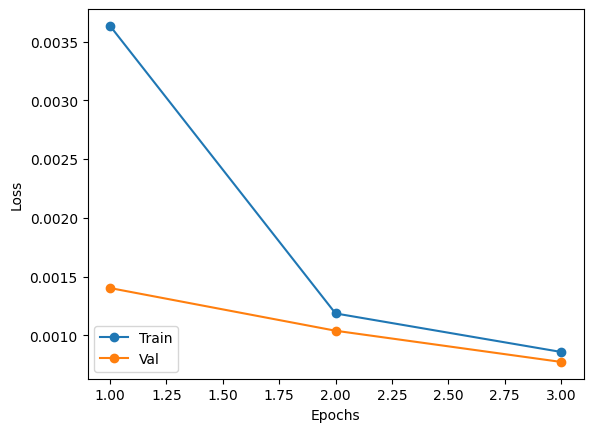

In [15]:
if(TRAIN_MODEL or LOAD_MODEL):
  xx = range(1,wrapper_autoencoder.elapsed_epochs+1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(xx, wrapper_autoencoder.training_loss, '-o', label = 'Train')
  plt.plot(xx, wrapper_autoencoder.validation_loss,'-o', label = 'Val')
  plt.legend(loc='lower left')

In [16]:
#if(TRAIN_MODEL or LOAD_MODEL):
if(False):

  slice_index = 100
  ax = 0

  im_test, lab = next(iter(val_loader))
  output = wrapper.predict(data = im_test)
  out = output[0]
  out_numpy = out.cpu().detach().numpy()
  im_test_numpy = im_test.cpu().detach().numpy()
  print(np.shape(im_test_numpy))

  plot_reconstruction(im_orig = np.sum(im_test_numpy[0], axis=0), im_rec = np.sum(out_numpy, axis = 0), ax = ax, slice_index = slice_index)
  plot_brain_sections([im_test[0], lab[0]], ax = ax, slice_index = slice_index)

In [17]:
#if(TRAIN_MODEL or LOAD_MODEL):
if(False):
  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(ker[0], allkernels=True)

  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(torch.sum(ker, dim=(0)), allkernels=True)

  kk = torch.sum(ker, dim= 0)
  kk = torch.sum(kk, dim = 0)
  plt.imshow(kk[0,:,:].cpu().detach().numpy())

  # Sum over the channels
  #ker =ker.sum(axis=(0,1))

## Filters extraction

In [18]:
new_features = True
# features v1 = quantiles 0.5 e 0.995 e 3 valori singolari più alti
# features v1 performano meglio
# features v2 = quantiles 0.25 0.5 0.75 0.995 a media valori singolari
bottleneck = autoencoder.decode[0][0][0].weight.detach().clone()
sum_bottleneck = bottleneck.sum(axis=(0,1)).flatten().cpu()
A,S,Vt = np.linalg.svd(sum_bottleneck.reshape(3,3,3))

quantile = get_quantiles(np.copy(sum_bottleneck))[-1]
filter_mean = sum_bottleneck.mean()
global_features = []
input_feats = 20
if(new_features):
    input_feats = 25
    for el in S:
        global_features.append(el[0])
    global_features.append(quantile)
    global_features.append(filter_mean.detach().clone().item())
    global_features = np.array(global_features, dtype=np.float32)


## GNN

In [19]:
#! rm -r  '/content/drive/MyDrive/Lorusso/BraTS/data/interim/processed_15000_0.5_0'

#! mkdir  '/content/drive/MyDrive/Lorusso/BraTS/data/interim/processed_15000_0.5_0'
#! mkdir  '/content/drive/MyDrive/Lorusso/BraTS/data/interim/processed_15000_0.1_0'

#t = os.listdir('/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.5_0/brats')[:10]
#v = os.listdir('/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.5_0/brats')[10:20]
#for el in t:
#    shutil.copytree(f"/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.5_0/brats/{el}", f"/content/drive/MyDrive/Lorusso/BraTS/data/interim/processed_15000_0.5_0/train/{el}")
#for el in v:
#    shutil.copytree(f"/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.5_0/brats/{el}", f"/content/drive/MyDrive/Lorusso/BraTS/data/interim/processed_15000_0.5_0/val/{el}")

Found 1001 MRIs
Found 125 MRIs
Found 125 MRIs
Elapsed epochs: 11
[0.83067578 0.4411215  0.36858974]
Epoch: 12/19, Step: 1/167, Training Loss: 0.1796, Elapsed time: 14 sec [0.90762686 0.89664708 0.84868067]
Epoch: 12/19, Step: 2/167, Training Loss: 0.1529, Elapsed time: 26 sec [0.91152312 0.89494605 0.86277372]
Epoch: 12/19, Step: 3/167, Training Loss: 0.1011, Elapsed time: 39 sec [0.89676425 0.91515994 0.88721805]
Epoch: 12/19, Step: 4/167, Training Loss: 0.0990, Elapsed time: 51 sec [0.85023738 0.81369248 0.8540305 ]
Epoch: 12/19, Step: 5/167, Training Loss: 0.2057, Elapsed time: 63 sec [0.90775255 0.91428571 0.85662867]
Epoch: 12/19, Step: 6/167, Training Loss: 0.1454, Elapsed time: 76 sec [0.81646091 0.86464771 0.85292671]
Epoch: 12/19, Step: 7/167, Training Loss: 0.1804, Elapsed time: 89 sec [0.89556174 0.78068044 0.82277671]
Epoch: 12/19, Step: 8/167, Training Loss: 0.1573, Elapsed time: 102 sec [0.87293275 0.73874806 0.88647746]
Epoch: 12/19, Step: 9/167, Training Loss: 0.1722, E

2024/01/28 20:38:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



val_wt_dice:  0.8846
val_ct_dice:    0.8474
val_at_dice:    0.8707
Epoch: 19/19, Mean Validation Loss: 0.2099, Elapsed time: 1847 sec

Total training time: 15048 sec


2024/01/28 20:38:33 WARNING mlflow.utils.requirements_utils: Found dgl version (2.0.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'dgl==2.0.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


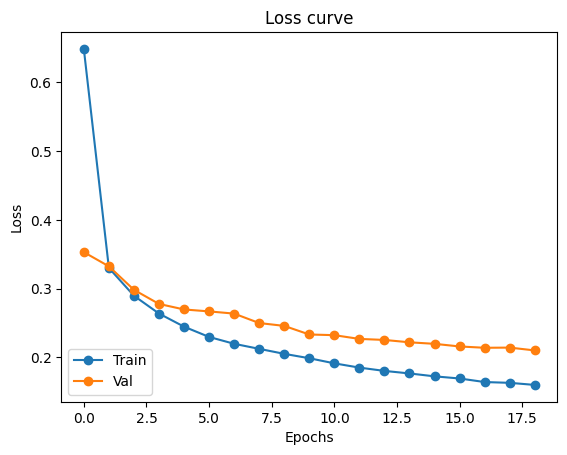

In [20]:
###############################
# Allenare sage con i nuovi dati
#################################
import torch.nn.functional as F
INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.1_0' #

TRAIN_PATH = os.path.join(INPUT_PATH,'train')
VAL_PATH = os.path.join(INPUT_PATH,'val')
TEST_PATH = os.path.join(INPUT_PATH,'test') # set to 'test' in production


train_dataset = ImageGraphDataset(TRAIN_PATH,'BraTS2021',read_image=False,read_graph=True,read_label=True, glob_features=global_features)
val_dataset = ImageGraphDataset(VAL_PATH,'BraTS2021',read_image=False,read_graph=True,read_label=True, glob_features=global_features)
test_dataset = ImageGraphDataset(TEST_PATH,'BraTS2021',read_image=False,read_graph=True,read_label=True, glob_features=global_features)


model_name = 'GraphSage'
TRAIN_MODEL = True
LOAD_MODEL = True # resume training

supervised = True
eval_metrics = None
num_workers = 0

batch_size = 6
num_epochs = 8
lr = 5e-4
#input_feats = 20

# val weights torch.Tensor([ 1.07, 23.0, 110.7, 72.2])
# train weights torch.Tensor([ 1.06, 26.15, 127.05, 83.67]).to(device) #torch.Tensor([0.1, 2.2, 10.5, 7]).to(device)
class_weights = torch.Tensor([0.2, 1, 3, 3]).to(device)
layer_sizes=[256]*4
n_classes=4
aggregator_type='mean'

k_val=3
heads = [128]*3
residuals = [128]*3
heads = [8, 8, 8, 8, 8, 8]
residuals = [False, True, True, False, True, True]
activation = F.relu
val_dropout = 0.1
val_feat_drop = 0.2
val_attn_drop = 0.2

model = None

if(model_name == 'GraphSage'):
    #run_id = '42365d77ea8c47b6b6fbf9d938ea5f65'
    dict_params = {k:eval(k) for k in ['val_dropout','input_feats', 'class_weights', 'layer_sizes', 'aggregator_type']}
    model = GraphSage(in_feats=input_feats,
                  layer_sizes=layer_sizes,
                  n_classes=n_classes,
                  aggregator_type=aggregator_type,
                  dropout=val_dropout)
elif(model_name == 'GIN'):
    dict_params = {k:eval(k) for k in ['val_dropout','input_feats', 'class_weights', 'layer_sizes']}
    model = GIN(in_feats=input_feats,
                  layer_sizes=layer_sizes,
                  n_classes=n_classes,
                  dropout=val_dropout)
elif(model_name == 'ChebNet'):
    model = ChebNet(input_feats, layer_sizes, n_classes, k_val, val_dropout)
    dict_params = {k:eval(k) for k in ['val_dropout','input_feats', 'class_weights', 'k_val', 'layer_sizes']}
elif(model_name == 'GAT'):
    dict_params = {k:eval(k) for k in ['val_dropout', 'val_feat_drop','val_attn_drop','input_feats', 'class_weights', 'layer_sizes', 'activation', 'heads', 'residuals']}
    model = GAT(in_feats = input_feats, layer_sizes = layer_sizes, n_classes=n_classes,heads = heads, residuals = residuals, activation = activation,  feat_drop = val_feat_drop, attn_drop = val_attn_drop)


optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
#loss_fn = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
#loss_fn = LossBraTS(focal=False)

wrapper = ModelWrapper(model = model,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            supervised = supervised,
                            dict_params = dict_params,
                            isgnn = True,
                            num_epochs = num_epochs,
                            LOAD_MODEL = LOAD_MODEL,
                            eval_metrics = eval_metrics,
                          )
                            #run_id = '42365d77ea8c47b6b6fbf9d938ea5f65'


train_loader = DataLoader(dataset = train_dataset,
                             batch_size = batch_size,
                             num_workers = num_workers,
                              collate_fn=minibatch_graphs)

val_loader = DataLoader(dataset = val_dataset,
                             batch_size = batch_size,
                             num_workers = num_workers,
                              collate_fn=minibatch_graphs)



print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

if(TRAIN_MODEL):
    training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = val_loader )
    #torch.cuda.empty_cache()

if(LOAD_MODEL):
  xx_train = range(len(wrapper.training_loss))
  xx_val = range(len(wrapper.validation_loss))
  plt.title('Loss curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(xx_train, wrapper.training_loss, '-o', label = 'Train')
  plt.plot(xx_val, wrapper.validation_loss,'-o', label = 'Val')
  plt.legend(loc='lower left')

In [21]:
! rm -r '/content/drive/MyDrive/Lorusso/BraTS/data/segmentation/BraTS2023-ValidationData/'
! mkdir '/content/drive/MyDrive/Lorusso/BraTS/data/segmentation/BraTS2023-ValidationData/'

In [22]:
#testdata2023 = ImageGraphDataset('/content/drive/MyDrive/Lorusso/BraTS/data/processed_15000_0.5_0/BraTS2023-ValidationData','BraTS-GLI-',read_image=False,read_graph=True,read_label=False)
#predictions = wrapper.predict_graph(testdata2023)
#seg_to_challenge()

In [23]:
#rm_run('BraTS_GraphSage',[	'50144ee94c044e65b36faa631448a56a'	,'ef211f890cfd40719edeb48128bf5ed0'])

# TESTING SECTION 🚧

In [24]:
#from skimage.segmentation import mark_boundaries
#dataset = ImageGraphDataset(TRAIN_PATH,'BraTS2021',read_image=True,read_graph=False,read_label=True, features=None)
#img, lab = dataset.get_image(dataset.all_ids[12])
#slic = dataset.get_supervoxel_partitioning(dataset.all_ids[12])
#img = img.sum(axis=3)
##img = img[90,:,:]
##img = img[90,:,:]
#img =   img[90,:,:].T
#slic = slic[90,:,:].T
#
## Display result
#fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
#ax1, ax2, ax3,ax4 = ax_arr.ravel()
#
#ax1.imshow(img,cmap='gray')
#ax1.set_title('Original image')
#
#ax3.imshow(mark_boundaries(img, slic))
#ax3.contour(slic, colors='red', linewidths=1)
#ax3.set_title('SLIC')
#
#for ax in ax_arr.ravel():
#    ax.set_axis_off()
#
#plt.tight_layout()
#plt.show()
#

In [25]:
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/train
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/test
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/val



#trainset = set()
#valset = set()
#testset = set()
#for el in dp.get_status_ids()['Pending']:
#    if(el in train_dataset.all_ids):
#        trainset.add(el)
#    if(el in val_dataset.all_ids):
#        valset.add(el)
#    if(el in test_dataset.all_ids):
#        testset.add(el)
#
#
#for el in valset:
#    src = VAL_PATH+'/'+str(el)
#    dst = '/content/drive/MyDrive/Lorusso/BraTS/data/processed_5000_0.5_10/brats/'+el
#    shutil.copytree(src, dst)

## Autoencoder

In [26]:

TEST_MODE = False


if(TEST_MODE):

    INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled'
    INPUT_PATH_PARENT = '/'.join(INPUT_PATH.split('/')[:-1])
    TRAIN_PATH = os.path.join(INPUT_PATH_PARENT,'train')
    VAL_PATH = os.path.join(INPUT_PATH_PARENT,'val')
    TEST_PATH = os.path.join(INPUT_PATH_PARENT,'test')

    TRAIN_MODEL = False
    LOAD_MODEL = True # resume training

    num_workers = 0
    batch_size = 1
    num_epochs = 2
    lr = 0.01
    supervised = False
    eval_metrics = [nn.MSELoss()]

  # MONAI AUTOENCODER
    model = AutoEncoder(
           spatial_dims=3,
           kernel_size = 3,
           up_kernel_size = 3,
           in_channels=4,
           out_channels=4,
           channels=(5,),
           strides=(2,),
           inter_channels=(8, 16, 32),
           inter_dilations=(1, 2, 4),
           num_inter_units=2
       )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-10)
    loss_fn = nn.MSELoss() #SSIMLoss(spatial_dims=3)

    wrapper = ModelWrapper(model = model,
                              loss_fn = loss_fn,
                              optimizer = optimizer,
                              supervised = supervised,
                              num_epochs = num_epochs,
                              LOAD_MODEL = LOAD_MODEL,
                              eval_metrics = eval_metrics
                          )

    dataset = DataPreprocessor(INPUT_PATH = INPUT_PATH)

    # Split dataset if it's not
    if(not os.path.exists(TRAIN_PATH)):
      dataset.split_dataset()


    train_dataset = DataPreprocessor(INPUT_PATH = TRAIN_PATH)
    val_dataset = DataPreprocessor(INPUT_PATH = VAL_PATH)
    test_dataset = DataPreprocessor(INPUT_PATH = TEST_PATH)

    train_loader = DataLoader(dataset = train_dataset,
                             sampler = SeqSampler(train_dataset),
                             batch_size = batch_size,
                             num_workers = num_workers)

    val_loader = DataLoader(dataset = val_dataset,
                             sampler = SeqSampler(val_dataset),
                             batch_size = batch_size,
                             num_workers = num_workers)

    test_loader = DataLoader(dataset = test_dataset,
                             sampler = SeqSampler(test_dataset),
                             batch_size = batch_size,
                             num_workers = num_workers)


    print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

    if(TRAIN_MODEL):
        training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = val_loader, experiment_prefix = 'Test' )
        torch.cuda.empty_cache()


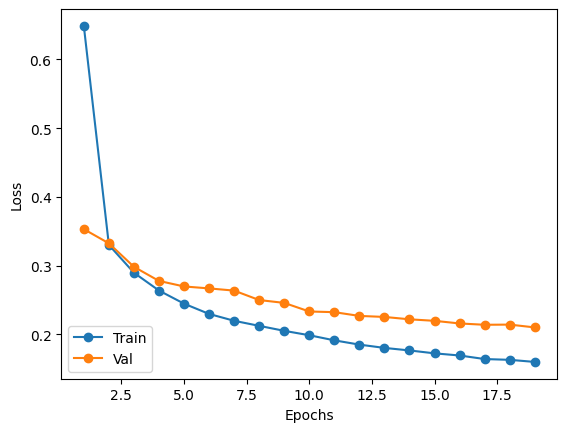

In [27]:
if(TRAIN_MODEL or LOAD_MODEL):
  xx = range(1,wrapper.elapsed_epochs+1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(xx, wrapper.training_loss, '-o', label = 'Train')
  plt.plot(xx, wrapper.validation_loss,'-o', label = 'Val')
  plt.legend(loc='lower left')

In [28]:
if(False):

  slice_index = 90
  ax = 0

  im_test, lab = next(iter(test_loader))
  output = wrapper.predict(data = im_test)
  out = output[0]
  out_numpy = out.cpu().detach().numpy()
  im_test_numpy = im_test.cpu().detach().numpy()

  plot_reconstruction(im_orig = np.sum(im_test_numpy[0], axis=0), im_rec = np.sum(out_numpy, axis = 0), ax = ax, slice_index = slice_index)
  plot_brain_sections([im_test[0], lab[0]], ax = ax, slice_index = slice_index)

In [29]:
if(False):
  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(ker[1], allkernels=True)

  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(torch.sum(ker, dim=(0)), allkernels=True)

  kk = torch.sum(ker, dim= 0)
  kk = torch.sum(kk, dim = 0)
  plt.imshow(kk[0,:,:].cpu().detach().numpy())

## Feature extraction

## GNN training ⛽

In [30]:

TEST_MODE = False


if(TEST_MODE):

    INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/processed_5000_0.5_10'
    TRAIN_PATH = os.path.join(INPUT_PATH,'train')
    VAL_PATH = os.path.join(INPUT_PATH,'val')
    TEST_PATH = os.path.join(INPUT_PATH,'val') # set again to 'test' in production

    TRAIN_MODEL = True
    LOAD_MODEL = False # resume training

    num_workers = 0
    batch_size = 1
    num_epochs = 2
    lr = 0.005
    supervised = True
    eval_metrics = []

    dropout = 0
    input_feats = 20
    class_weights = torch.Tensor([0.1,1,2,2])
    layer_sizes=[256]*4
    n_classes=4
    aggregator_type='pool'

    dict_params = {k:eval(k) for k in ['input_feats', 'class_weights', 'layer_sizes', 'n_classes', 'aggregator_type', 'n_classes']}

    model = GraphSage(in_feats=input_feats,layer_sizes=layer_sizes,n_classes=n_classes,aggregator_type=aggregator_type,dropout=dropout)

    optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=1e-10)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    wrapper = ModelWrapper(model = model,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            supervised = supervised,
                            dict_params = dict_params,
                            isgnn = True,
                            num_epochs = num_epochs,
                            LOAD_MODEL = LOAD_MODEL,
                            eval_metrics = eval_metrics
                          )


    train_dataset = ImageGraphDataset(VAL_PATH,'BraTS2021',read_image=False,read_graph=True,read_label=True)
    #val_dataset = ImageGraphDataset(VAL_PATH,'BraTS2021',read_image=False,read_graph=True,read_label=True)
    #test_dataset = ImageGraphDataset(TEST_PATH,'BraTS2021',read_image=False,read_graph=True,read_label=True)

    train_loader = DataLoader(dataset = train_dataset,
                             batch_size = batch_size,
                             num_workers = num_workers,
                              collate_fn=minibatch_graphs)


    print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

    if(TRAIN_MODEL):
        training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = train_loader, experiment_prefix = 'Test_GNN' )
        torch.cuda.empty_cache()
